In [40]:
from datasets import Dataset, load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    pipeline,
)
from peft import (
    LoraConfig,
    PeftModel,
    TaskType,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from trl import SFTConfig, SFTTrainer, DataCollatorForCompletionOnlyLM
import random
import numpy as np
import torch

## 数据集

In [2]:
dataset = load_dataset("lucasmccabe-lmi/CodeAlpaca-20k", split="train")

Using the latest cached version of the dataset since lucasmccabe-lmi/CodeAlpaca-20k couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /root/.cache/huggingface/datasets/lucasmccabe-lmi___code_alpaca-20k/default/0.0.0/dd8c2e1a6f61531f57e8c111bfebf756830ee410 (last modified on Sun Jan  5 07:09:31 2025).


In [41]:
SEED = 42

def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
seed_everything(SEED)

In [57]:
print(dataset)
print("------------")
print(dataset[0])
print("------------")
print(dataset[1])

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20022
})
------------
{'instruction': 'Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.', 'input': '', 'output': 'def f(x):\n    """\n    Takes a specific input and produces a specific output using any mathematical operators\n    """\n    return x**2 + 3*x'}
------------
{'instruction': 'Generate a unique 8 character string that contains a lowercase letter, an uppercase letter, a numerical digit, and a special character. Write corresponding code in Python.', 'input': '', 'output': "import string\nimport random\n\ndef random_password_string():\n    characters = string.ascii_letters + string.digits + string.punctuation\n    password = ''.join(random.sample(characters, 8))\n    return password\n\nif __name__ == '__main__':\n    print(random_password_string())"}


In [58]:
def formatting_prompts_func(example):
    output_texts = []
    for i in range(len(example['instruction'])):
        text = f"### Question: {example['instruction'][i]}\n ### Answer: {example['output'][i]}"
        output_texts.append(text)
    return output_texts

output_texts = formatting_prompts_func(dataset[:2])
print(output_texts[0])
print("------------")
print(output_texts[1])

### Question: Create a function that takes a specific input and produces a specific output using any mathematical operators. Write corresponding code in Python.
 ### Answer: def f(x):
    """
    Takes a specific input and produces a specific output using any mathematical operators
    """
    return x**2 + 3*x
------------
### Question: Generate a unique 8 character string that contains a lowercase letter, an uppercase letter, a numerical digit, and a special character. Write corresponding code in Python.
 ### Answer: import string
import random

def random_password_string():
    characters = string.ascii_letters + string.digits + string.punctuation
    password = ''.join(random.sample(characters, 8))
    return password

if __name__ == '__main__':
    print(random_password_string())


## 模型

In [59]:
model = AutoModelForCausalLM.from_pretrained(
        "/workspace/LLM-finetune/codeLLM/huggingface/unsloth/facebook-opt-350m",
        device_map="auto",)
tokenizer = AutoTokenizer.from_pretrained(
        "/workspace/LLM-finetune/codeLLM/huggingface/unsloth/facebook-opt-350m",
        device_map="auto",)
model

nvidia-smi: line 14: /usr/bin/data-set: No such file or directory


OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features

In [60]:
model.config

OPTConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "/workspace/LLM-finetune/codeLLM/huggingface/unsloth/facebook-opt-350m",
  "_remove_final_layer_norm": false,
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "architectures": [
    "OPTForCausalLM"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 2,
  "do_layer_norm_before": false,
  "dropout": 0.1,
  "enable_bias": true,
  "eos_token_id": 2,
  "ffn_dim": 4096,
  "hidden_size": 1024,
  "init_std": 0.02,
  "layer_norm_elementwise_affine": true,
  "layerdrop": 0.0,
  "max_position_embeddings": 2048,
  "model_type": "opt",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "prefix": "</s>",
  "torch_dtype": "float16",
  "transformers_version": "4.46.3",
  "use_cache": true,
  "vocab_size": 50272,
  "word_embed_proj_dim": 512
}

In [61]:
tokenizer

GPT2TokenizerFast(name_or_path='/workspace/LLM-finetune/codeLLM/huggingface/unsloth/facebook-opt-350m', vocab_size=50265, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '</s>', 'eos_token': '</s>', 'unk_token': '</s>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False),  added_tokens_decoder={
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}

In [62]:
tokenizer.chat_template  # none
response_template = " ### Answer:"
collator = DataCollatorForCompletionOnlyLM(response_template, tokenizer=tokenizer)

## 训练

In [63]:
config = LoraConfig(
    r=16,  # LoRA的秩，影响LoRA矩阵的大小
    lora_alpha=32,  # LoRA适应的比例因子
    # 指定将LoRA应用到的模型模块，通常是attention和全连接层的投影
    target_modules = ["q_proj", "k_proj", "v_proj", "out_proj", "fc_in", "fc_out"],
    lora_dropout=0.05,  # 在LoRA模块中使用的dropout率
    bias="none",  # 设置bias的使用方式，这里没有使用bias
    # task_type="CAUSAL_LM"  # 任务类型，这里设置为因果(自回归）语言模型
)

model = get_peft_model(model, config)

In [64]:
model.print_trainable_parameters()
# 获取当前模型占用的 GPU显存（差值为预留给 PyTorch 的显存）
memory_footprint_bytes = model.get_memory_footprint()
memory_footprint_mib = memory_footprint_bytes / (1024 ** 3)  # 转换为 GB

print(f"{memory_footprint_mib:.2f}GB")

trainable params: 3,145,728 || all params: 334,342,144 || trainable%: 0.9409
1.25GB


In [67]:
model_dir = "/workspace/LLM-finetune/codeLLM/outputs"
model_id  = "opt-350m"
training_args = SFTConfig(
        output_dir=f"{model_dir}/{model_id}-lora",  # 指定模型输出和保存的目录
        per_device_train_batch_size=8,  # 每个设备上的训练批量大小
        learning_rate=1e-4,  # 学习率
        max_seq_length=1024,
        # fp16=True,  # 启用混合精度训练，可以提高训练速度，同时减少内存使用
        logging_steps=10,  # 指定日志记录的步长，用于跟踪训练进度
        # max_steps=100, # 最大训练步长
        num_train_epochs=1,  # 训练的总轮数
        save_strategy="steps",
        warmup_ratio=0.1,
        lr_scheduler_type="constant",
        report_to="wandb",
        save_safetensors=True,
        seed=SEED,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    # args=training_args,
    args=training_args,
    formatting_func=formatting_prompts_func,
    data_collator=collator,
)

nvidia-smi: line 14: /usr/bin/data-set: No such file or directory


In [68]:
trainer.train()

Step,Training Loss
10,1.859600
20,1.891400
30,1.725500
40,1.671900
50,1.628100
60,1.859600
70,1.772900
80,1.878100
90,1.664500
100,1.761100


TrainOutput(global_step=2503, training_loss=1.4788031585684216, metrics={'train_runtime': 659.7463, 'train_samples_per_second': 30.348, 'train_steps_per_second': 3.794, 'total_flos': 9838668820807680.0, 'train_loss': 1.4788031585684216, 'epoch': 1.0})

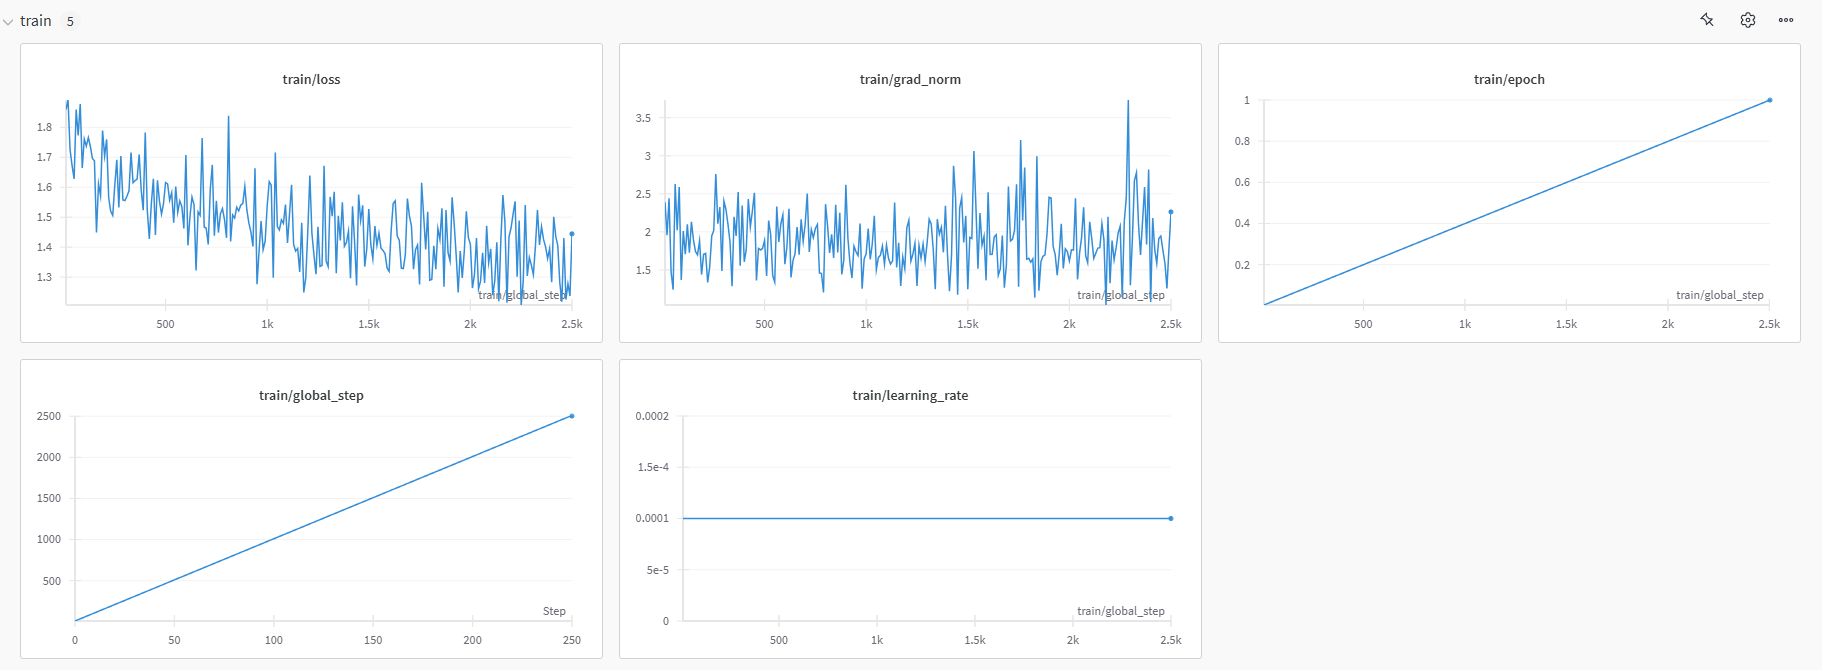

## 保存模型

In [70]:
new_model = "/workspace/LLM-finetune/codeLLM/huggingface/unsloth/facebook-opt-350m-CodeAlpaca"
trainer.save_model(new_model)

## 推理

In [90]:
lora_model = trainer.model

In [95]:
text = "Create a function that takes an integer 100 as a parameter and returns the sum of all integers from 1 up to and including 100. Write the corresponding code in Java."
inputs = tokenizer(text, return_tensors="pt").to(0)

out = lora_model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(out[0], skip_special_tokens=True))

print("-----------")
out1 = model.generate(**inputs, max_new_tokens=100)
print(tokenizer.decode(out1[0], skip_special_tokens=True))

Create a function that takes an integer 100 as a parameter and returns the sum of all integers from 1 up to and including 100. Write the corresponding code in Java.

public static int sumOfAll(int[] arr) {
    int sum = 100;
    for (int i = 1; i < arr.length; i++) {
        sum += arr[i];
    }
    return sum;
}

public static int sumOfAll(int arr) {
    int sum = 100;
    for (int
-----------
Create a function that takes an integer 100 as a parameter and returns the sum of all integers from 1 up to and including 100. Write the corresponding code in Java.

function sumOfAllNodes(num) {
    sum = 100;
    return sum;
}

// Output:
// Output:
// sum = 100;
// sum = 100;
// sum = 100;
// sum = 100;
// sum = 100;
// sum = 100;
// sum = 100;
// sum = 100;
// sum = 100;
// sum = 100;
//


## 评估性能